# Session 8: Navigation - EKF
In this tutorial you will learn how to implement an Extended Kalman Filter in python using numpy.

The learning outcomes of this tutorial are:
* Use matrices in python with numpy
* Implement Extended Kalman Filter
* Implement three different update functions
* Use EKF with dead reckoning and USBL data

## Implementation of Vector and Matrix

Inside our sess6072_tutorials library, the implementation of Vector and Matrix is hidden. If you use this functions somewhere else, consider copying the functions or replacing them for the original calls to numpy.


In [1]:
import numpy as np
from math import sin, cos
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def Vector(dim):
    return np.zeros((dim, 1), dtype=float)

def Matrix(dim1, dim2=0):
    if dim2 > 0:
        return np.zeros((dim1, dim2), dtype=float)
    else:
        return np.zeros((dim1, dim1), dtype=float)

def Identity(dim):
    return np.eye(dim, dtype=float)

def Inverse(m):
    return np.linalg.inv(m)

def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

def plot_EKF_trajectory(states, covariances, flip=False, measurements=None):
    _ = plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, aspect="equal")
    i = 0
    for s, c in zip(states, covariances):
        if i % 5 == 0:
            vals, vecs = eigsorted(c[0:2, 0:2])
            theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
            if flip:
                e = Ellipse(
                    xy=(s[1], s[0]), width=vals[0], height=vals[1], angle=theta
                )
            else:
                e = Ellipse(
                    xy=(s[0], s[1]), width=vals[0], height=vals[1], angle=theta
                )
            e.set_alpha(0.2)
            e.set_facecolor("red")
            ax.add_patch(e)
        i += 1
    xpos = [s[0] for s in states]
    ypos = [s[1] for s in states]
    if flip:
        plt.plot(ypos, xpos, "bo-")
    else:
        plt.plot(xpos, ypos, "bo-")
    plt.xlabel("X (m)")
    plt.ylabel("Y (m)")
    plt.grid(True)
    plt.axis("equal")

    if measurements is not None:
        for i in range(len(measurements)):
            circle = plt.Circle(
                (measurements[i]["N"], measurements[i]["E"]), 0.2, color="g"
            )
            circle.set_alpha(0.2)
            ax = plt.gca()
            ax.add_patch(circle)
            plt.plot(measurements[i]["N"], measurements[i]["E"], "gx")
    plt.show()
    
def gaussian(mu, sigma, x):  
    return 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-(x-mu)**2/(2*(sigma**2)))

def kalman_plot(mu,Sigma,pred_mu, pred_Sigma, cor_mu,cor_Sigma, z, h, Q, x=None):
    if x is None:
        x = np.arange(-8,8,0.05)
    pred_z, H = h(pred_mu)
    # note Sigma is the covariance and the gaussian function implemented here is for the standard deviation (i.e., sqrt(cov))
    plt.plot(x,gaussian(pred_mu[0,0], np.sqrt(pred_Sigma[0,0]), x),'r',linewidth=3, label ='Predict (Prior)')
    plt.plot(x,gaussian(H[0,0]*z[0,0], np.sqrt(Q[0,0]), x),'b',linewidth=3, label ='Observe (Evid.)')
    plt.plot(x,gaussian(cor_mu[0,0], np.sqrt(cor_Sigma[0,0]), x),'g',linewidth=3, label ='Correct (Post.)')
    plt.xlabel('x'); plt.ylabel('f(x)'); plt.legend()

In [2]:
x = Vector(5)
print('5x1 vector:\n',x,'\n')

# This is how we declare a 5x5 matrix with numpy
x = Matrix(5)
print('Empty 5x5:\n',x,'\n')

# This is how we change their values:
x[1,2] = 1000
print('Not empty anymore:\n',x,'\n')

# We can also declare identity matrices:
x_id = Identity(5)
print('Identity:\n',x_id,'\n')

# We can transpose matrices with the operator .T
x_transposed = x.T
print('x:\n',x,'\n')
print('x.T:\n',x_transposed,'\n')

# And we can inverse matrices with np.linalg.inv()
B = Identity(2)
B[1,1] = 10
Binv = Inverse(B)
print('Binv:\n',Binv,'\n')

# And finally, the matrix product is defined by the operator @

should_be_identity = Binv @ B
print('Identity?:\n',should_be_identity)

# We can check the number of elements of a matrix or vector using its method .size
print('\nSize of B is: ',B.size)

# We can check the shape of a matrix or vector using its method .size
print('\nShape of B is: ',B.shape)

5x1 vector:
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]] 

Empty 5x5:
 [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]] 

Not empty anymore:
 [[   0.    0.    0.    0.    0.]
 [   0.    0. 1000.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]] 

Identity:
 [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]] 

x:
 [[   0.    0.    0.    0.    0.]
 [   0.    0. 1000.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]] 

x.T:
 [[   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0. 1000.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]] 

Binv:
 [[1.  0. ]
 [0.  0.1]] 

Identity?:
 [[1. 0.]
 [0. 1.]]

Size of B is:  4

Shape of B is:  (2, 2)


## Extended Kalman Filter

<img src="images/ekf_steps.png" width="600"/>

In [11]:
def ekf_predict(state, covariance, control_input, f, process_noise, dt, params = None):
    """ EKF Prediction step

    Args:
      state (np.ndarray): State mean
      covariance (np.ndarray): State covariance
      control_input (np.ndarray): Control input
      f (Callable): Function f(state, control_input, dt, params) that returns the estimated state and its jacobian
      process_noise (np.ndarray): Process noise
      dt (float): Time step
      params (dict): Parameters dictionary - useful to pass parameters to "f"
    """
    # (1) Project the state forward: x = Ax + Bu (really, x = f(x, u))
    est_state, F = f(state, control_input, dt, params)

    # (2) Project the error forward: 
    est_covariance = (F @ covariance @ F.T) + process_noise*dt
    
    # Return the estimated state and the covariance
    return est_state, est_covariance
    
def ekf_correct(est_state, est_covariance, z, h, measurement_noise):
    """ EKF Correction step

    Args:
      est_state (np.ndarray): Estimated state mean
      est_covariance (np.ndarray): Estimated state covariance
      measurement_z (np.ndarray): Measurement input
      h (Callable): Measurement model function that returns the estimated measurement and its jacobian
      measurement_noise (np.ndarray): Measurement noise
    """
    # Prepare the estimated measurement
    est_measurement_z, H = h(est_state)
        
    # (3) Compute the Kalman gain
    K = est_covariance @ H.T @ Inverse(H @ est_covariance @ H.T + measurement_noise)
    
    # (4) Compute the updated state estimate
    corrected_state = est_state + K @ (z - est_measurement_z)

    # (5) Compute the updated state covariance
    corrected_covariance = (Identity(est_state.shape[0]) - K @ H) @ est_covariance
    
    # Return the state and the covariance
    return corrected_state, corrected_covariance

### Exercise: Tiniest EKF example you can think of
If $f(x_{k}) = \mathbf{x}^2_{k-1}+\mathbf{u}_k$, and $h(x_{k}) = \mathbf{x}_{k}$ we have:

Motion model: $ \left\lbrace \begin{eqnarray}
\mathbf{x}_k &=& \mathbf{x}^2_{k-1} + \mathbf{u}_k + \epsilon_k\\
R_k &=& \epsilon^2_k
\end{eqnarray}\right.$

Observation model $ \left\lbrace \begin{eqnarray}
\mathbf{z}_{k} &=& \mathbf{x}_{k} + \delta_k\\
Q_k &=& \delta^2_k
\end{eqnarray}\right.$

In [12]:
def f_nonlin(state, control_vector, dt, params):
    # this is a non-linear model that cannot be solved with a KF f(x)=x**2+u

    pred_state = state**2 + control_vector
    F = 2*state

    return pred_state, F

def h_nonlin(state):

    est_measurement = state
    H = Matrix(1)
    H[0,0] = 1

    return est_measurement, H

Start with the previous belief of $[\mu,\Sigma]=[0,1]$ and change the control vector, measurement vector, process noise and measurement noise to get a feel for how things work.

Control: u =[[-2.]], Process noise: R =[[1.]]
Observation: z =[[1.]], Measurement noise: Q =[[2.]]
Previous state : state =[[0.]], covariance=[[1.]]
Prediction: state =[[-2.]], covariance=[[1.]]
Correction: state =[[-1.]], covariance=[[0.66666667]]


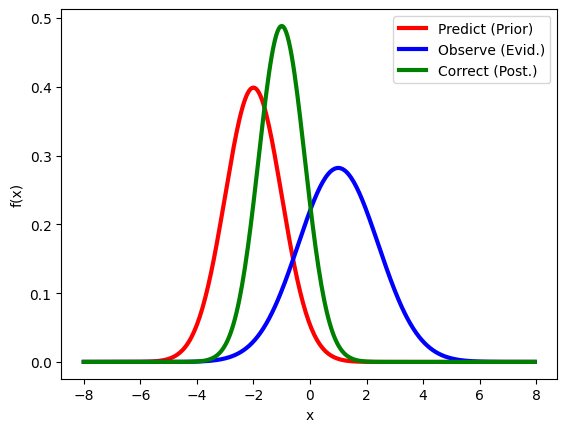

In [13]:
zm = Matrix(1)
om = Matrix(1); om[0, 0] = 1

state = zm; covariance = om # Previous belief
control_vector = -2*om; z = om  # Control vector; Measurement vector
R = om; Q = 2*om  # Process noise; Measurement noise
dt = 1  # timestep

pred_state, pred_covariance = ekf_predict(state, covariance, control_vector, f_nonlin, R, dt)
cor_state, cor_covariance = ekf_correct(pred_state, pred_covariance, z, h_nonlin, Q)

print('Control: u =' + str(control_vector) + ', Process noise: R =' + str(R))
print('Observation: z =' + str(z) + ', Measurement noise: Q =' + str(Q))
print('Previous state : state =' + str(state) + ', covariance=' + str(covariance))
print('Prediction: state =' + str(pred_state) + ', covariance=' + str(pred_covariance))
print('Correction: state =' + str(cor_state) + ', covariance=' + str(cor_covariance))

kalman_plot(state, covariance, pred_state, pred_covariance, cor_state,cor_covariance, z, h_nonlin, Q)

## Implement EKF for a 2-D AUV

Implement an EKF for a 2-D vehicle with the following state vector:

$$ \mathbf{x} = (N, E, \psi , \dot N, \dot E, \dot \psi) $$

where,

* $N$ is the northing position in metres
* $E$ is the easting position in metres
* $\psi$ is the orientation in radians
* $\dot N$ is the northing speed in m/s
* $\dot E$ is the easting speed in m/s
* $\dot \psi$ is the body y speed in m/s

your motion model $f(\mathbf{x}_{k}) $ is a constant speed 2D model, defined as:

\begin{equation*}
f(\mathbf{x}_{k}) \left\lbrace \begin{array}{l}
N_{k} &= N_{k} + \frac{1}{2}(\dot N _{k-1} + \dot N_k)\Delta t\\
E_{k} &= E_{k} + \frac{1}{2}(\dot E _{k-1} + \dot E_k)\Delta t \\
\psi_{k} &=  \psi_{k-1} + \frac{1}{2}(\dot \psi _{k-1} + \dot \psi_k)\Delta t \\
\dot N_{k} &=  \dot N_{k-1} + \left(  \frac{F^*_{N,thrust}(\mathbf{u_k}) - F^*_{N,drag}}{m+m_{added}} \right)\Delta t \\
\dot E_{k} &=  \dot E_{k-1} + \left(  \frac{F^*_{E,thrust}(\mathbf{u_k}) - F^*_{E,drag}}{m+m_{added}} \right)\Delta t\\
\dot \psi_{k} &=  \dot\psi_{k-1} + \left( \frac{M_{\psi,thrust}^*(\mathbf{u_k}) - B_{66}\dot\psi_{k-1}}{I+a_{66}} \right)\Delta t  \end{array} \right.
\end{equation*}

and its jacobian ${F}_{k}$ is:

\begin{equation*}
{F}_{k} = \left( \begin{array}{cccccc} 
1 & 0 & 0 & \Delta t & 0 & 0 \\
0 & 1 & 0 & 0 & \Delta t & 0 \\
0 & 0 & 1 & 0 & 0 & \Delta t \\
0 & 0 & 0 & 1-k_{D/M}\frac{2\dot N^2+\dot E^2}{(\dot N^2 + \dot E^2)^{0.5}}\Delta t & -k_{D/M}\frac{\dot N\dot E}{(\dot N^2 + \dot E^2)^{0.5}}\Delta t & 0 \\
0 & 0 & 0 & -k_{D/M}\frac{\dot N\dot E}{(\dot N^2 + \dot E^2)^{0.5}}\Delta t & 1-k_{D/M}\frac{\dot N^2+2\dot E^2}{(\dot N^2 + \dot E^2)^{0.5}}\Delta t & 0 \\
0 & 0 & 0 & 0 & 0 & 1 - k_{B/I}\Delta t
\end{array} \right)
\end{equation*}


In [ ]:
# Easy names for indexing
N = 0
E = 1
O = 2
DOTN = 3
DOTE = 4
DOTO = 5

# define model parameters
params = {
    'k_drag': 70, #from 0.5*\rho*C_D*A
    'total_mass': 10,
    'total_I': 0.03,
    'B_66': 0.01
}

def motion_model(state, control_input, dt, params=None):
    # Read the state vars of timestep (k-1)
    N_k_1 = state[N]
    E_k_1 = state[E]
    theta_k_1 = state[O]
    dot_N_k_1 = state[DOTN]
    dot_E_k_1 = state[DOTE]
    dot_theta_k_1 = state[DOTO]

    # Placeholders for state vars of timestep (k)
    N_k = 0.0
    E_k = 0.0
    theta_k = 0.0
    dot_N_k = 0.0
    dot_E_k = 0.0
    dot_theta_k = 0.0

    # Enforce populated params
    if params is None:
        print('This motion model needs the parameters "total_mass", "k_drag", "total_I" and "B_66" defined.')
        print('Please populate them in a dictionary and pass them to the function call')
        return None, None
    valid_params = ['total_mass', 'k_drag', 'total_I', 'B_66']
    for valid_param in valid_params:
        if valid_param not in params:
            print("Missing parameter", valid_param, "in the motion model. Aborting.")
            return None, None
    total_mass = params['total_mass']
    k_drag = params['k_drag']
    total_I = params['total_I']
    B_66 = params['B_66']

    # Control input is u = (Tx, Ty, Mz) 
    # (e.g. thrust in surge and sway in the body frame, and a yaw moment)
    # First, we will convert it to thrust in northings and eastings
    thrust_N = None  # Fill in yourself
    thrust_E = None  # Fill in yourself
    moment_theta = None  # Fill in yourself

    # Compute rotational acceleration, rate and orientation from torque equilibrium
    dotdot_theta_k = None  # Fill in yourself
    dot_theta_k = None  # Fill in yourself
    theta_k = None  # Fill in yourself

    # Compute acceleration from force equilibrium
    dotdot_N_k = None  # Fill in yourself
    dotdot_E_k = None  # Fill in yourself
    dot_N_k = None  # Fill in yourself
    dot_E_k = None  # Fill in yourself
    N_k = None  # Fill in yourself
    E_k = None  # Fill in yourself

    # Angle wrapping (?)
    theta_k = (theta_k + np.pi) % (2 * np.pi) - np.pi
    
    # Populate the output vector
    predicted_state = Vector(6)
    predicted_state[N] = N_k
    predicted_state[E] = E_k
    predicted_state[O] = theta_k
    predicted_state[DOTN] = dot_N_k
    predicted_state[DOTE] = dot_E_k
    predicted_state[DOTO] = dot_theta_k

    # Compute its jacobian
    F = Identity(6)
    F[N, DOTN] = dt
    F[E, DOTE] = # Fill in yourself
    F[O, DOTO] = dt
    n2e2=np.sqrt(dot_N_k**2+dot_E_k**2)
    if n2e2 > 1E-8:
        F[DOTN, DOTN] = # Fill in yourself
        F[DOTN, DOTE] = # Fill in yourself
        F[DOTE, DOTE] = 1-((k_drag/total_mass)*((dot_N_k**2+2*dot_E_k**2)/n2e2))*dt
        F[DOTE, DOTN] = -((k_drag/total_mass)*((dot_N_k*dot_E_k)/n2e2))*dt
        F[DOTO, DOTO] = 1-B_66/total_I*dt
    
    return predicted_state, F

## Check the motion model

In [ ]:
state = Vector(6)
control_input = Vector(3)
control_input[0] = 1.1
control_input[1] = 2.1
control_input[2] = 0.3
dt = 1.0

For the values:

```
control_input[0] = 1.1
control_input[1] = 2.1
control_input[2] = 0.3
dt = 1.0
```

Starting at origin, you should see the output of the first iteration as

```
Predicted at: ['0.06', '0.11', '-1.28', '0.11', '0.21', '10.00']
```

and on the second iteration:

```
Predicted at: ['0.19', '0.12', '-0.52', '0.16', '-0.18', '16.67']
```

In [ ]:
print('Starting at:', ['{0:0.2f}'.format(i) for i in state.flatten().tolist()])
print('with control input:', ['{0:0.2f}'.format(i) for i in control_input.flatten().tolist()], 'for', dt, 'seconds')
state, F = motion_model(state, control_input, dt, params)
print('Predicted at:', ['{0:0.2f}'.format(i) for i in state.flatten().tolist()])

Let's see how to define an orientation and position updates. 

For example, the measurement function $h_{s}(\boldsymbol{x})$ for an orientation update is:

$$ h_{s}(\mathbf{x_{k}}) = \left\lbrace \begin{array}{l}
N_{k} &= 0 \\
E_{k} &= 0 \\
\psi_{k} &=  \psi_{k} \\
\dot E_{k} &=  0 \\
\dot N_{k} &=  0 \\
\dot\psi_{k} &=  0  \end{array} \right. $$

and its jacobian $ {H}_{s}^{k+1} $ is defined as


$$ {H}_{s}^{k+1} = \left( \begin{array}{cccccc} 
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0
\end{array} \right)$$

can you work out what are the measurement function and the jacobian for a position update?

In [ ]:
def h_orientation_update(x):
    est_measurement = Vector(5)
    H = Matrix(5)
    
    # Modify the measurement and the H
    
    return est_measurement, H


def h_position_update(x):
    est_measurement = Vector(5)
    H = Matrix(5)
    
    # Modify the measurement and the H
    
    return est_measurement, H

## Create our set of measurements 

To test our implementation, lets create a set of virtual measurements and use them with the EKF we just implemented.

In [ ]:
heading_std = 0.1

orientation_list = []
control_list = []

heading = 0
thrust_x = 10.0
moment_z = 0.0

ts = np.arange(0, 20.1, 0.1)

for t in ts:
    if t > 10:
        heading = 1.57 
        thrust_x = 10.0
        moment_z = 0.065
    if t > 10.3:
        thrust_x = 10.0
        moment_z = 0.0
    ori_m = {
        'epoch_timestamp': t + np.random.uniform(0, 0.05),
        'heading': heading,
        'heading_std': heading_std
    }
    control_m = {
        'epoch_timestamp': t + np.random.uniform(0, 0.05),
        'thrust_x': thrust_x,
        'thrust_y': 0.0,
        'moment_z': moment_z,
    }
    orientation_list.append(ori_m)
    control_list.append(control_m)
    
ots = [x['epoch_timestamp'] for x in orientation_list[0:20]]
cts = [x['epoch_timestamp'] for x in control_list[0:20]]
plt.figure()
plt.plot(ots, np.ones(len(ots)), 'o', label="Orientation")
plt.plot(cts, np.ones(len(cts))*2, 'o', label="Control")
plt.legend()
plt.ylim([0, 3])
plt.show()

Read the control inputs with your motion model. What maneuver is the vehicle doing?

In [ ]:
state = Vector(6)
control_input = Vector(3)
t = 0
states = []
for i in range(len(control_list)):
    control_input[0] = control_list[i]['thrust_x']
    control_input[1] = control_list[i]['thrust_y']
    control_input[2] = control_list[i]['moment_z']
    dt = control_list[i]['epoch_timestamp'] - t
    t += dt
    state, F = motion_model(state, control_input, dt, params)
    states.append(state)

plot_EKF_trajectory(states, [], flip=True)

We will declare our initial state and covariance. The initial position will be (0, 0) traveling at a speed of (1.0, 0) at an orientation of zero degrees. 

The initial covariance has been already defined for you below.

In [ ]:
init_state = Vector(6)
init_state[N] = 0.0
init_state[E] = 0.0
init_state[O] = 0.0
init_state[DOTN] = 1.0
init_state[DOTE] = 0.0
init_state[DOTO] = 0.0

print('State:')
print(init_state)

init_covariance = Identity(6) * 0.02
init_covariance[O, O] = 0.2
init_covariance[DOTN, DOTN] = 0.001
init_covariance[DOTE, DOTE] = 0.001
init_covariance[DOTO, DOTO] = 0.001

print('\nState covariance:')
print(init_covariance)

R = Identity(6) * 0.05
print('\nNoise covariance:')
print(R)

# Note that we have no measurements or control
u = zm
z = zm
Q = Identity(6) * 1.0 # Measurement noise

## Implement the entire EKF

In the cell below, implement an EKF to fuse the velocity and orientation measurements generated above.

In [ ]:
states = [init_state]
covariances = [init_covariance]
timestamps = [0]
state = init_state
covariance = init_covariance

# define model parameters
params = {
    'k_drag': 70, #from 0.5*\rho*C_D*A
    'total_mass': 10,
    'total_I': 0.03,
    'B_66': 0.01
}

t = 0.0
sim_time = 20.0
default_dt = 0.01

control_idx = 0
orientation_idx = 0

while t < sim_time:    
    # Check which timestamp to process first
    
    
    # Predict with EKF to the most recent timestamp
    
    
    # Update EKF with the most recent measurement
    
    
    # Save the EKF states, covariance and timestamps 
    states.append(state)
    covariances.append(covariance)
    timestamps.append(t)
    t += dt
    
plot_EKF_trajectory(states, covariances)

### Plot the position error during the mission

In [ ]:
n_std = [np.sqrt(x[N, N]) for x in covariances]
e_std = [np.sqrt(x[E, E]) for x in covariances]

plt.figure()
plt.plot(timestamps, n_std, label='Northings std')
plt.plot(timestamps, e_std, label='Eastings std')
plt.xlabel("Time (s)")
plt.ylabel("Standard deviation (m)")
plt.legend()
plt.show()

## Add position measurements

We will add a two position measurements
* One at the instant $t=11.03\,s$ that reads (3.9, 0.5).
* A second at the instant $t=18.04\,s$ that reads (4.1, 3.1).

We will also set the covariance of this measurement to 0.5 squared meters.

In [ ]:
n_std = 0.5
e_std = 0.5
position_list = [
    {
         'epoch_timestamp': 11.03,
         'N': 3.9,
         'E': 0.5,
         'N_std': n_std,
         'E_std': e_std
    },
    {
        'epoch_timestamp': 18.04,
         'N': 4.1,
         'E': 3.1,
         'N_std': n_std,
         'E_std': e_std
    }
]

Let's visualise where these measurements would fall, on our previous run:

In [ ]:
# Show previous solution for comparison
print("Without position update")
plot_EKF_trajectory(states, covariances, measurements=position_list)

In [ ]:
%matplotlib inline

states2 = [init_state]
covariances2 = [init_covariance]
timestamps2 = [0]
state = init_state
covariance = init_covariance

# Note that we ignore control inputs at the start
u = Vector(3)

# define model parameters
params = {
    'k_drag': 70, #from 0.5*\rho*C_D*A
    'total_mass': 10,
    'total_I': 0.03,
    'B_66': 0.01
}

t = 0.0
sim_time = 20.0
default_dt = 0.01

while t < sim_time:    
    # Check which timestamp to process first
    
    
    # Predict with EKF to the most recent timestamp
    
    
    # Update EKF with the most recent measurement
    
    
    # Save the EKF states, covariance and timestamps 
    states2.append(state)
    covariances2.append(covariance)
    timestamps2.append(t)
    t += dt

print("With position update")
plot_EKF_trajectory(states2, covariances2, measurements=position_list)

### Plot the position error during the mission

In [ ]:
n_std = [np.sqrt(x[N, N]) for x in covariances2]
e_std = [np.sqrt(x[E, E]) for x in covariances2]

plt.figure()
plt.plot(timestamps2, n_std, label='Northings std')
plt.plot(timestamps2, e_std, label='Eastings std')

plt.annotate('Position update', xy=(11, 0.4),  xycoords='data',
            xytext=(0.5, 0.2), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top')

plt.annotate('Position update', xy=(18.0, 0.4),  xycoords='data',
            xytext=(0.8, 0.2), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top')
plt.xlabel("Time (s)")
plt.ylabel("Standard deviation (m)")
plt.legend()
plt.show()

## Towards your assignments

For your build assignment you will implement an EKF with two types of updates:
* USBL updates (position)
* AHRS updates (orientation)

you have used all these updates in this tutorial.

### How to explore and read AUV data, and perform dead-reckoning

To read in and explore AUV data, please refer to the [deadreckoning notes and tutorial in blackboard](https://blackboard.soton.ac.uk/webapps/blackboard/content/listContentEditable.jsp?content_id=_5441626_1&course_id=_197422_1)
